In [ ]:
import pandas as pd
import numpy as np

# Load your dataset (replace with the path to your actual CSV file)
df = pd.read_csv('output_with_updated_tec.csv')

# Function to handle negative values and zeros by replacing them with NaN
def handle_invalid_values(df, columns):
    for col in columns:
        df[col] = df[col].apply(lambda x: np.nan if x <= 0 else x)  # Replace <=0 with NaN
    return df

# Handle invalid values (negative and zero) in 'F10.7obs' and 'SN'
df = handle_invalid_values(df, ['F10.7obs', 'SN'])

# Interpolate missing values (NaN) using linear interpolation
df['F10.7obs'] = df['F10.7obs'].interpolate(method='linear')
df['SN'] = df['SN'].interpolate(method='linear')

# Optionally, you can save the cleaned dataset back to CSV
df.to_csv('Cleaned_Solar_Cycle_SN_Peaks.csv', index=False)

# Print the updated DataFrame (optional)
print(df[['F10.7obs', 'SN']].head())  # Show a preview of the updated columns


   F10.7obs  SN
0       NaN NaN
1     69.70 NaN
2     68.95 NaN
3     68.20 NaN
4     68.50 NaN


In [ ]:
import pandas as pd
import numpy as np

# Load your dataset (replace with the path to your actual CSV file)
df = pd.read_csv('output_with_updated_tec.csv')

# Function to handle negative values and zeros by replacing them with NaN
def handle_invalid_values(df, columns):
    for col in columns:
        df[col] = df[col].apply(lambda x: np.nan if x <= 0 else x)  # Replace <=0 with NaN
    return df

# Handle invalid values (negative and zero) in 'F10.7obs' and 'SN'
df = handle_invalid_values(df, ['F10.7obs', 'SN'])

# Step 2: Interpolate (linear interpolation) to estimate the missing values
df['F10.7obs'] = df['F10.7obs'].interpolate(method='linear')
df['SN'] = df['SN'].interpolate(method='linear')

# Optionally, you can save the cleaned dataset back to CSV
df.to_csv('Cleaneds.csv', index=False)

# Print the updated DataFrame (optional)
print(df[['F10.7obs', 'SN']].head())  # Show a preview of the updated columns


   F10.7obs  SN
0       NaN NaN
1     69.70 NaN
2     68.95 NaN
3     68.20 NaN
4     68.50 NaN


In [ ]:
import pandas as pd
import numpy as np

# Load your dataset (replace with the path to your actual CSV file)
df = pd.read_csv('output_with_updated_tec.csv')

# Function to handle negative values and zeros by replacing them with NaN
def handle_invalid_values(df, columns):
    for col in columns:
        # Replace values <= 0 with NaN
        df[col] = df[col].apply(lambda x: np.nan if x <= 0 else x)
    return df

# Handle invalid values (negative and zero) in 'F10.7obs' and 'SN'
df = handle_invalid_values(df, ['F10.7obs', 'SN'])

# Step 2: Interpolate (linear interpolation) to estimate the missing values
df['F10.7obs'] = df['F10.7obs'].interpolate(method='linear', limit_direction='both')
df['SN'] = df['SN'].interpolate(method='linear', limit_direction='both')

# Optionally, you can save the cleaned dataset back to CSV
df.to_csv('Cleaned.csv', index=False)

# Print the updated DataFrame (optional)
print(df[['F10.7obs', 'SN']].head())  # Show a preview of the updated columns


   F10.7obs    SN
0     69.70  11.0
1     69.70  11.0
2     68.95  11.0
3     68.20  11.0
4     68.50  11.0


In [ ]:
import pandas as pd
import numpy as np

# Load the dataset
df = pd.read_csv("Cleaned.csv")

# Ensure that the 'Date' column is a datetime object
df['Date'] = pd.to_datetime(df['Date'])

# Create Lag Features
df['TEC_Lag1'] = df['TEC (TECU)'].shift(1)
df['TEC_Lag2'] = df['TEC (TECU)'].shift(2)

# Create Rolling Features (7-day rolling mean and std deviation)
df['TEC_Rolling_Mean'] = df['TEC (TECU)'].rolling(window=7).mean()
df['TEC_Rolling_Std'] = df['TEC (TECU)'].rolling(window=7).std()

# Extract time-based features (Month, Day, Weekday)
df['Month'] = df['Date'].dt.month
df['Day'] = df['Date'].dt.day
df['Weekday'] = df['Date'].dt.weekday

# Create Kp Mean from kp1 to kp8
df['Kp_mean'] = df[['Kp1', 'Kp2', 'Kp3', 'Kp4', 'Kp5', 'Kp6', 'Kp7', 'Kp8']].mean(axis=1)

# Add Sunspot and F10.7 observations
df['Sunspot'] = df['SN']
df['F107'] = df['F10.7obs']

# Add interaction feature between Kp mean and F107
df['Kp_F107'] = df['Kp_mean'] * df['F107']

# Drop rows with NaN values (caused by lagging and rolling operations)
df = df.dropna()


In [ ]:
from sklearn.preprocessing import MinMaxScaler

# Define the target and features
target = 'TEC (TECU)'  # Make sure the column name matches your dataset
features = ['TEC_Lag1', 'TEC_Lag2', 'TEC_Rolling_Mean', 'TEC_Rolling_Std', 'Month', 'Day', 'Weekday', 'Kp_mean', 'Sunspot', 'F107', 'Kp_F107']

# Prepare X (features) and Y (target) arrays
X = df[features].values
y = df[target].values

# Scale the features and target using MinMaxScaler (necessary for LSTM)
scaler_X = MinMaxScaler(feature_range=(0, 1))
scaler_Y = MinMaxScaler(feature_range=(0, 1))

X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_Y.fit_transform(y.reshape(-1, 1))

# Split the data into train and test sets (use a time-based split)
train_size = int(len(df) * 0.8)
X_train, X_test = X_scaled[:train_size], X_scaled[train_size:]
y_train, y_test = y_scaled[:train_size], y_scaled[train_size:]


In [ ]:
# Reshape the data into 3D format for LSTM (samples, time steps, features)
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Build the LSTM model
model = Sequential()

# LSTM layer with 50 units and input shape (1, number of features)
model.add(LSTM(units=50, return_sequences=False, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))  # Dropout to prevent overfitting
model.add(Dense(units=1))  # Output layer for predicting TEC

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 0.1788 - val_loss: 0.0265
Epoch 2/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0162 - val_loss: 0.0125
Epoch 3/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0110 - val_loss: 0.0077
Epoch 4/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0082 - val_loss: 0.0036
Epoch 5/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0066 - val_loss: 0.0023
Epoch 6/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0051 - val_loss: 0.0017
Epoch 7/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0046 - val_loss: 0.0014
Epoch 8/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0043 - val_loss: 0.0014
Epoch 9/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0040 - val_loss: 0.0012
Epoch 10/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0040 - val_loss: 0.0011
Epoch 11/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0039 - val_loss: 0.0011
Epoch 12/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0035 - val_l

In [ ]:
# Evaluate the model
loss = model.evaluate(X_test, y_test)
print(f'Model Loss: {loss}')

# Predict the TEC (TECU) for the test set
y_pred_scaled = model.predict(X_test)

# Inverse scale the predictions and true values to get original TEC values
y_pred = scaler_Y.inverse_transform(y_pred_scaled)
y_test_original = scaler_Y.inverse_transform(y_test)

# Calculate performance metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

mae = mean_absolute_error(y_test_original, y_pred)
rmse = np.sqrt(mean_squared_error(y_test_original, y_pred))
mape = mean_absolute_percentage_error(y_test_original, y_pred)

print(f'MAE: {mae}')
print(f'RMSE: {rmse}')
print(f'MAPE: {mape}')


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.2186e-04
Model Loss: 0.000474738102639094
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
MAE: 1.2717591877054864e+17
RMSE: 1.592222165923048e+17
MAPE: 0.028649475700865405


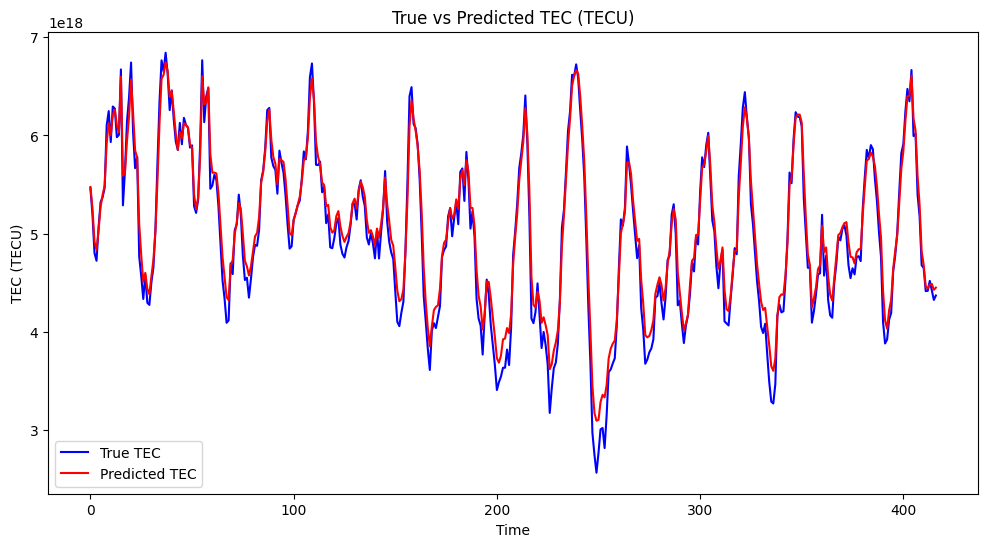

In [ ]:
import matplotlib.pyplot as plt

# Plot the true vs predicted values for TEC
plt.figure(figsize=(12, 6))
plt.plot(y_test_original, label='True TEC', color='blue')
plt.plot(y_pred, label='Predicted TEC', color='red')
plt.title('True vs Predicted TEC (TECU)')
plt.xlabel('Time')
plt.ylabel('TEC (TECU)')
plt.legend()
plt.show()
